# Train a Neural Network - Alternative with Keras

The following cells show how the alternative use of [keras](https://keras.io/) and [tensorflow](https://www.tensorflow.org/) would look like to set up the same model for our regression task.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import load_model

import optuna

In [ ]:
# Tensorflow error handling
#tf.config.optimizer.set_jit(False)
#tf.config.experimental.enable_op_determinism()
#tf.random.set_seed(1)
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.config.list_physical_devices()

## Load and prepare data 

In [2]:
df = pd.read_csv('data/HB_data.csv', sep=',')

df_val = df.sample(frac=0.05, random_state=42)
df_tt = df.drop(df_val.index)

target_col = "energy"
X = df_tt.drop(columns=[target_col])
y = df_tt[target_col].to_numpy().reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Preprocess and transform features
numerical_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

# Define scaling and encoding for X
x_preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ],
    remainder="drop",
)
# Define scaling for y
y_scaler = StandardScaler()

# Fit scaling for X on train data only, apply (transform) scaling to both train and test
X_train_t = x_preprocessor.fit_transform(X_train)
X_test_t = x_preprocessor.transform(X_test)

# Fit scaling for y on train data only, apply (transform) scaling to both train and test
y_train_t = y_scaler.fit_transform(y_train)
y_test_t = y_scaler.transform(y_test)

# Get transformed feature names (handy for inspection)
feat_names = x_preprocessor.get_feature_names_out()
    
# Inspect transformed data
print("X_train: ", X_train_t.shape)
print("X_test:  ", X_test_t.shape)
print("y_train: ", y_train_t.shape)
print("y_test:  ", y_test_t.shape)
display(pd.DataFrame(X_train_t, columns=feat_names).head(5))

X_train:  (1244, 16)
X_test:   (312, 16)
y_train:  (1244, 1)
y_test:   (312, 1)


,num__bo-acc,num__bo-donor,num__q-acc,num__q-donor,num__q-hatom,num__dist-dh,num__dist-ah,cat__atomtype-acc_Cl,cat__atomtype-acc_F,cat__atomtype-acc_N,cat__atomtype-acc_O,cat__atomtype-acc_S,cat__atomtype-don_F,cat__atomtype-don_N,cat__atomtype-don_O,cat__atomtype-don_S
0,-1.285813,0.917745,-0.115091,-0.282173,0.864921,-0.662341,1.298361,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.647649,0.186561,0.970476,-0.771634,-0.619231,-0.258013,1.832981,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-1.162635,-0.394051,0.083728,-0.078369,0.426753,-0.294188,0.813984,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.306321,-0.886830,0.274388,0.630579,0.169388,-0.271833,-1.260058,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,2.782975,0.231048,-2.398073,-1.403848,-1.551664,-0.384992,-0.519736,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
# Define the model with a parameterizable architecture with Keras
def create_model(in_dim, hidden=(64, 32), dropout=0.1, lr=1e-3, weight_decay=1e-5):
    inputs = keras.Input(shape=(in_dim,))
    x = inputs
    for h in hidden:
        x = layers.Dense(
            h,
            activation="relu",
            kernel_regularizer=regularizers.l2(weight_decay)
        )(x)
        x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    return model

In [5]:
# Define function for training loop with hyperparameter configuration
# Also define a directory to store model checkpoints during training
CKPT_DIR = "optuna_ckpts"
os.makedirs(CKPT_DIR, exist_ok=True)

def objective(trial):
    hidden_layers_list = [(256,128,64), (128,64), (64,32), (64,)]
    idx = trial.suggest_int("hidden_layers_idx", 0, len(hidden_layers_list)-1)
    hidden_layers = hidden_layers_list[idx]
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("lr", 5e-4, 3e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16,32,64,128,256])
    epochs = 50

    best_rmse = float("inf")
    best_model_path = os.path.join(CKPT_DIR, f"best_trial.keras")

    model = create_model(
        in_dim=X_train_t.shape[1],
        hidden=hidden_layers,
        dropout=dropout,
        lr=lr,
        weight_decay=weight_decay,
    )

    history = model.fit(
        X_train_t, y_train_t,
        validation_data=(X_test_t, y_test_t),
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
    )

    # Evaluate in original units (unscaled y)
    y_pred = y_scaler.inverse_transform(model.predict(X_test_t))
    y_true = y_scaler.inverse_transform(y_test_t)
    val_rmse = math.sqrt(np.mean((y_pred - y_true) ** 2))

    # Store model if model improved
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        model.save(best_model_path)
    
    # Report to optuna
    trial.set_user_attr("keras_history", history.history)
    trial.set_user_attr("best_model", best_model_path)

    return val_rmse

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, timeout=600)

In [7]:
best_trial = study.best_trial
best_params = best_trial.params
display("Params:", best_params)
print("Best RMSE:", best_trial.value)

'Params:'

{'hidden_layers_idx': 1,
 'dropout': 0.03851177664057214,
 'lr': 0.0009183114007974771,
 'weight_decay': 5.794506140272295e-05,
 'batch_size': 64}

Best RMSE: 2.553923289711433


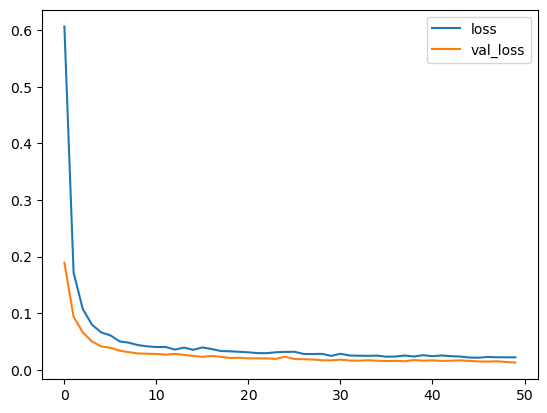

In [8]:
# Analyze the best trials history
history_dict = best_trial.user_attrs["keras_history"]

df_history = pd.DataFrame(history_dict)
df_history[['loss', 'val_loss']].plot(legend=True)
plt.show()

In [9]:
best_model_path = best_trial.user_attrs["best_model"]
best_model = load_model(best_model_path)
best_model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,605 (37.52 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,404 (25.02 KB)